In [1]:
%matplotlib widget

In [2]:

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as sp
import databento as db 
import zstandard as zstd
from databento import DBNStore
import math
import matplotlib.animation as animation # for animation
import datetime

In [4]:
# switching to dask
from dask.distributed import LocalCluster
cluster = LocalCluster(memory_limit='24GB').get_client()

import dask.dataframe as dd

import dask.array as da

In [5]:
bclr=['r','b','g','m','y','c','k']

notebook_dir="/home/rupam/Rupam_pcloud/Quantitative Finance/Quant_researcher_Job/Strategic_prep/My_projects/"
data_path=notebook_dir+"Mini_S_and_P_futures_data/LOB_10/"


In [6]:
files=[data_path+f'glbx-mdp3-{day}.mbp-10.parquet' for day in ['20220202','20220203']]

In [7]:
%%time
df = dd.read_parquet(files,engine="pyarrow")

CPU times: user 553 ms, sys: 19.3 ms, total: 572 ms
Wall time: 574 ms


In [8]:
df.columns;
lvl_lst=['00','02']
cols=['ts_event','action','side','price','size']+[col for col in df.columns if any(lvl in col for lvl in lvl_lst)]+['symbol']
cols;

In [9]:
df['ts_event']=dd.to_datetime(df['ts_event'])

In [10]:
df=df[cols]
df_ESH2=df[(df['price']!=9223372036854775807) & (df['ts_event'].dt.time>datetime.time(9,0)) &(df['ts_event'].dt.time<=datetime.time(16,0))
   & (df['symbol']=='ESH2') & (df['bid_px_00'] <= df['ask_px_00']) & (df['bid_px_02'] <= df['ask_px_02'])] 

In [11]:
%%time
df_ESH2=df_ESH2.set_index('ts_event',sorted=True)

CPU times: user 751 ms, sys: 145 ms, total: 895 ms
Wall time: 10.6 s


In [48]:
df_ESH2.npartitions

2

In [49]:
df_ESH2.divisions

(Timestamp('2022-02-02 09:00:00.010196649'),
 Timestamp('2022-02-03 09:00:00.008991389'),
 Timestamp('2022-02-03 15:59:59.939418005'))

In [20]:
df_short_ESH2 = df_ESH2.repartition(npartitions=10).get_partition(0).persist()

In [32]:
df_short_ESH2.head(3)

,action,side,price,size,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,bid_px_02,ask_px_02,bid_sz_02,ask_sz_02,bid_ct_02,ask_ct_02,symbol
ts_event,,,,,,,,,,,,,,,,,
2022-02-02 09:00:00.010196649,T,B,4555250000000,3,4555000000000,4555250000000,3,9,3,8,4554500000000,4555750000000,18,20,13,14,ESH2
2022-02-02 09:00:00.010196649,C,A,4555250000000,1,4555000000000,4555250000000,3,6,3,5,4554500000000,4555750000000,18,20,13,14,ESH2
2022-02-02 09:00:00.010446033,A,B,4555000000000,1,4555000000000,4555250000000,4,6,4,5,4554500000000,4555750000000,18,20,13,14,ESH2


In [41]:
x=df_ESH2.loc['2022-02-02']['ask_px_00']
y=df_ESH2.loc['2022-02-02']['bid_px_00']
(x+y).compute()

ts_event
2022-02-02 09:00:00.010196649    9110250000000
2022-02-02 09:00:00.010196649    9110250000000
2022-02-02 09:00:00.010446033    9110250000000
2022-02-02 09:00:00.010469535    9110250000000
2022-02-02 09:00:00.010475639    9110250000000
                                     ...      
2022-02-02 15:59:59.967130623    9111250000000
2022-02-02 15:59:59.967256411    9111250000000
2022-02-02 15:59:59.974628641    9111250000000
2022-02-02 15:59:59.990175839    9111250000000
2022-02-02 15:59:59.990294449    9111250000000
Length: 3658146, dtype: int64

#Dask is not so user friendly as pandas

In [16]:
class BasicProp:
    def __init__(self,df):
        self.df=df
        self.lvl_list=lvl_lst
        
    def mid_price(self):
        mids={}
        for lvl in self.lvl_list:
            mids[f'mid_px_{lvl}']=(self.df[f'ask_px_{lvl}']+self.df[f'bid_px_{lvl}'])/2
        return dd.DataFrame(mids, index=self.df.index)
        
    def spread(self):
        sprd={}
        for lvl in self.lvl_list:
            sprd[f'spread_{lvl}']=self.df[f'ask_px_{lvl}']-self.df[f'bid_px_{lvl}']
        return pd.DataFrame(sprd, index=self.df.index)

    def rel_spread(self):
        rel_sprd={}
        for lvl in self.lvl_list:
            rel_sprd[f'rel_spread_{lvl}']=2*(self.df[f'ask_px_{lvl}']-self.df[f'bid_px_{lvl}'])/(self.df[f'ask_px_{lvl}']+self.df[f'bid_px_{lvl}'])
        return pd.DataFrame(rel_sprd, index=self.df.index)

    def ob_imbl(self):
        imbl={}
        for lvl in self.lvl_list:
            imbl[f'ob_imbl_{lvl}']=(self.df[f'bid_sz_{lvl}']-self.df[f'ask_sz_{lvl}'])/(self.df[f'bid_sz_{lvl}']+self.df[f'ask_sz_{lvl}'])
        return pd.DataFrame(imbl, index=self.df.index)

    def quote_return(self,case='log'):
        rtn={}
        for lvl in self.lvl_list:
            mid=(self.df[f'ask_px_{lvl}']+self.df[f'bid_px_{lvl}'])/2
            if case =='abs':
                rtn[f'abs_return_{lvl}']=mid.diff()/mid.shift(1) # or mid.pct_change()
            elif case =='log':
                rtn[f'log_return_{lvl}']=np.log(mid).diff()
        return pd.DataFrame(rtn, index=self.df.index)

    def volatility(self,win=1000):
        vol={}
        for lvl in self.lvl_list:
            mid=(self.df[f'ask_px_{lvl}']+self.df[f'bid_px_{lvl}'])/2
            rtn=mid.diff()/mid.shift(1)
            vol[f'vol_{lvl}_{win}']=rtn.rolling(window=win).std()
        return pd.DataFrame(vol, index=self.df.index)


In [11]:
ESH2_prop=BasicProp(df_ESH2)

In [12]:
def plot_time_series(df, title='Order Book Features', steps=10,):
    cols=df.columns
    n = len(cols)
    ncols= 2 if n>1 else 1
    nrows= math.ceil(n / ncols)
     

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.5 * ncols, 3.5 * nrows))
    axs = axs.flatten() if n > 1 else [axs]

    lines = []
    y_list = []

    for i in range(n):
        data = df.iloc[::steps]
        x = data.index.values
        y = data.values[:,i]
        ax = axs[i]
        ax.set_xlim(np.nanmin(x), np.nanmax(x))
        ax.set_ylim(np.nanmin(y), np.nanmax(y))
        ax.set_xlabel("Time index (sampled)")
        ax.set_ylabel("Value")
        ax.grid(True)
        line, = ax.plot([], [], label=cols[i], color=bclr[i], alpha=0.5)
        ax.legend()
        lines.append(line)
        y_list.append(y)    

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    def update(frame):
        for i in range(n):
            lines[i].set_data(x[:frame], y_list[i][:frame])
        return lines

    ani = animation.FuncAnimation(fig, update, frames=len(x), interval=20, blit=False, repeat=False)

    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.show()

    return ani


In [13]:
df_combined = pd.concat([ESH2_prop.spread(), ESH2_prop.mid_price(), ESH2_prop.ob_imbl(),ESH2_prop.quote_return(),ESH2_prop.volatility()], axis=1)

/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


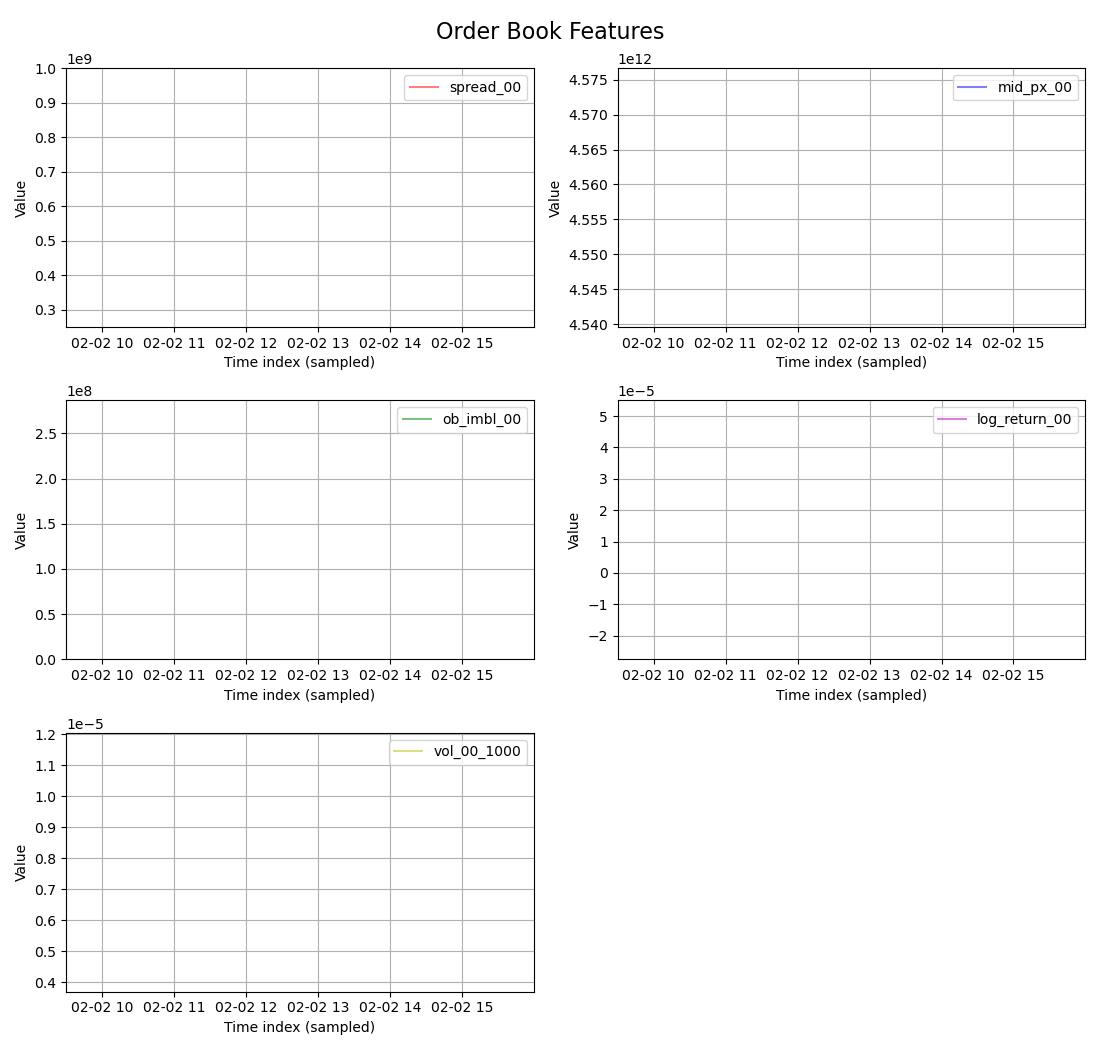

In [14]:
plot_time_series(df_combined,steps=10000)

In [15]:
#resampling in 1s and 5s bars

def time_resampler(df,delt):
    t0=pd.Timestamp('2022-02-02 09:30:00')
    dict_rs={}
    dt=pd.Timedelta(seconds=delt)
    while t0<df.index[-1]-dt:
        df_dt=df[t0:t0+dt]
        prop=BasicProp(df_dt)
        avg_pr=prop.mid_price().mean().values[0]
        avg_spread=prop.spread().mean().values[0]
        avg_return=prop.quote_return().mean().values[0]
        avg_imbl=prop.ob_imbl().mean().values[0]
        dict_rs[t0+dt]=(avg_pr,avg_spread,avg_return,avg_imbl)
        t0=t0+dt
    df_rs=pd.DataFrame.from_dict(dict_rs,orient='index',columns=['avg_mid_price','avg_spread','avg_return','avg_imbl'])
    df_rs.index.name='ts_event'
    return df_rs

In [16]:
df1s_ESH2=time_resampler(df_ESH2,1)

In [17]:
df1s_ESH2

,avg_mid_price,avg_spread,avg_return,avg_imbl
ts_event,,,,
2022-02-02 09:30:01,4.563797e+12,2.644509e+08,3.184855e-07,1.344465e+08
2022-02-02 09:30:02,4.563712e+12,3.256579e+08,-7.303935e-07,1.661393e+08
2022-02-02 09:30:03,4.563625e+12,2.500000e+08,0.000000e+00,1.363636e-01
2022-02-02 09:30:04,4.563625e+12,2.500000e+08,0.000000e+00,1.080586e-01
2022-02-02 09:30:05,4.563779e+12,3.031915e+08,1.190859e-06,2.121115e+08
...,...,...,...,...
2022-02-02 15:59:56,4.556449e+12,2.626404e+08,0.000000e+00,8.683009e+07
2022-02-02 15:59:57,4.556469e+12,2.662338e+08,7.144196e-08,8.000813e+07
2022-02-02 15:59:58,4.556196e+12,2.781186e+08,-2.248758e-07,8.596846e+07


/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


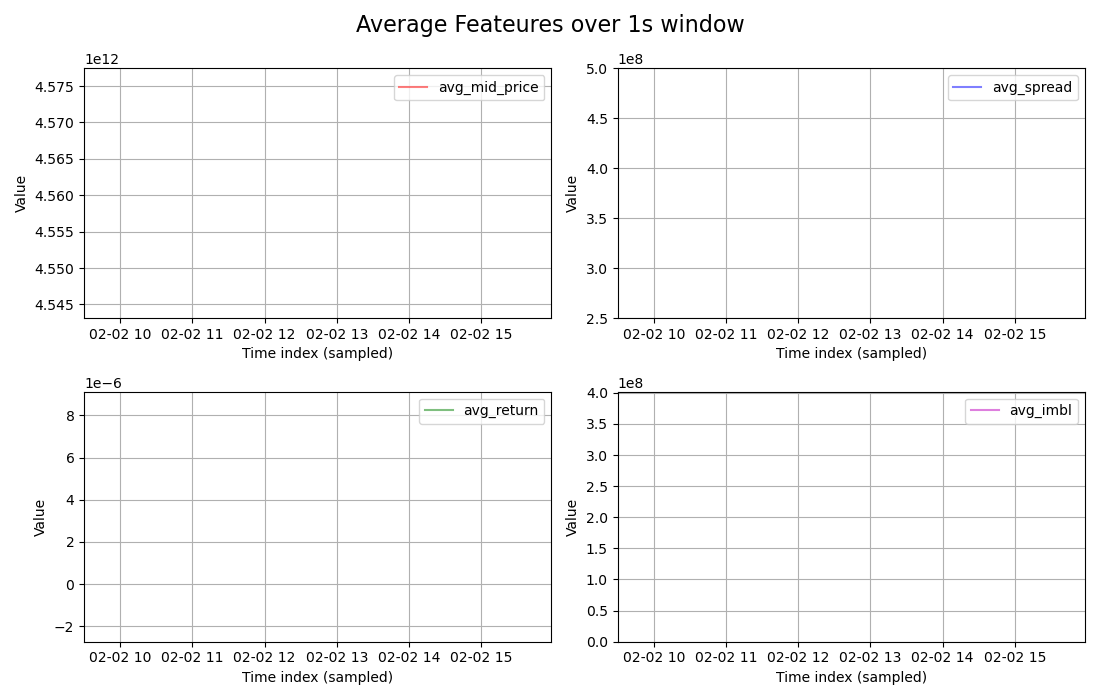

In [18]:
plot_time_series(df1s_ESH2,'Average Feateures over 1s window', steps = 100)

In [19]:
df5s_ESH2=time_resampler(df_ESH2,5)

/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


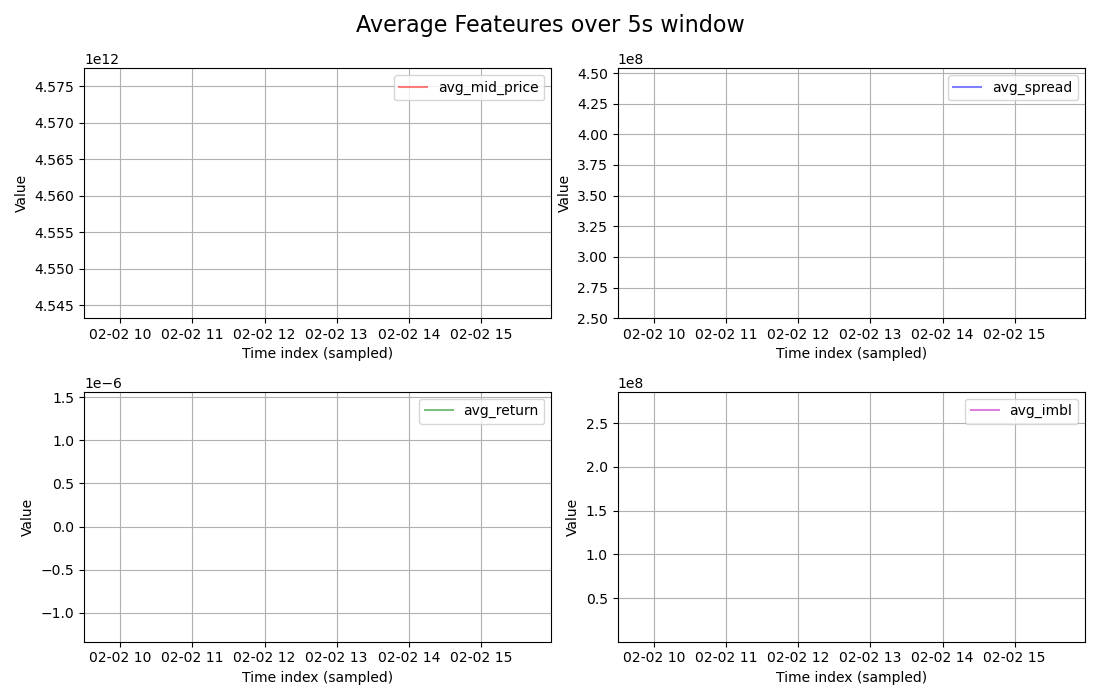

In [20]:
plot_time_series(df5s_ESH2,'Average Feateures over 5s window', steps = 20)

In [21]:
def plot_histogram(df,title='Histogram of avg quantities',bins=100):
    cols=df.columns
    n = len(cols)
    ncols= 2 if n>1 else 1
    nrows= math.ceil(n / ncols)
     

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.5 * ncols, 3.5 * nrows))
    axs = axs.flatten() if n > 1 else [axs]


    for i in range(n):
        ax = axs[i]
        ax.set_xlabel(cols[i])
        ax.set_ylabel("Frequency")
        ax.grid(True)
        counts,bin_edges,patches = ax.hist(df[cols[i]],bins=bins, label=cols[i], color=bclr[i],edgecolor='black',alpha=0.5)
        ax.set_xlim(np.nanmin(bin_edges), np.nanmax(bin_edges))
        #ax.set_ylim(np.nanmin(counts), np.nanmax(counts))
        ax.legend()

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.show()

/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


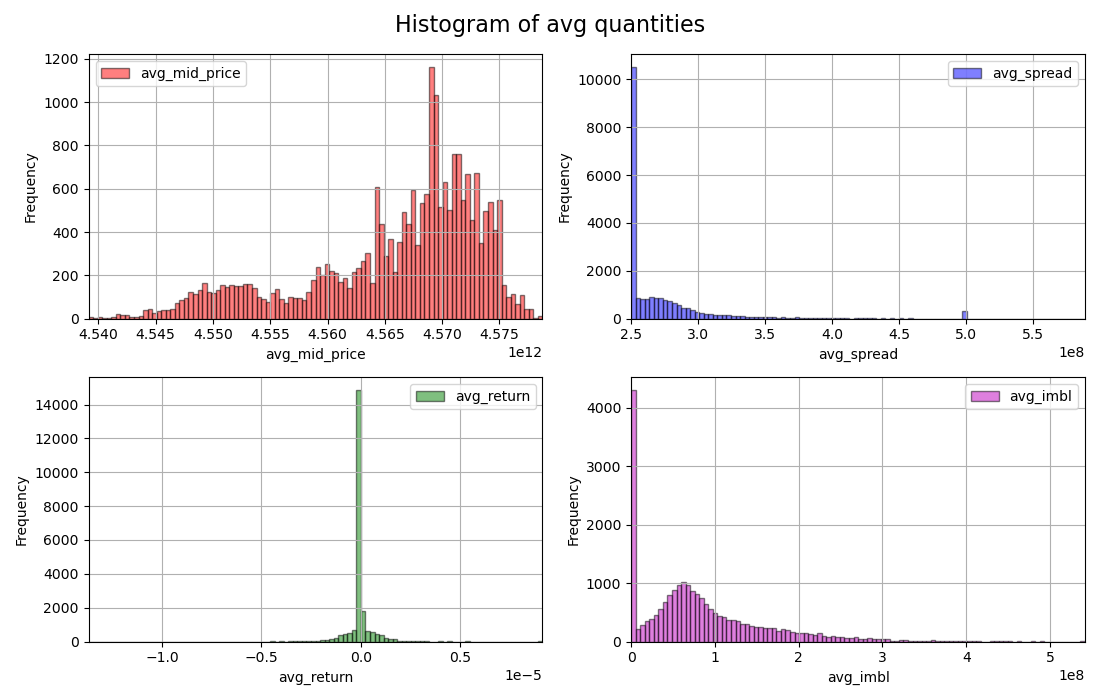

In [22]:
plot_histogram(df1s_ESH2,bins=100)


/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


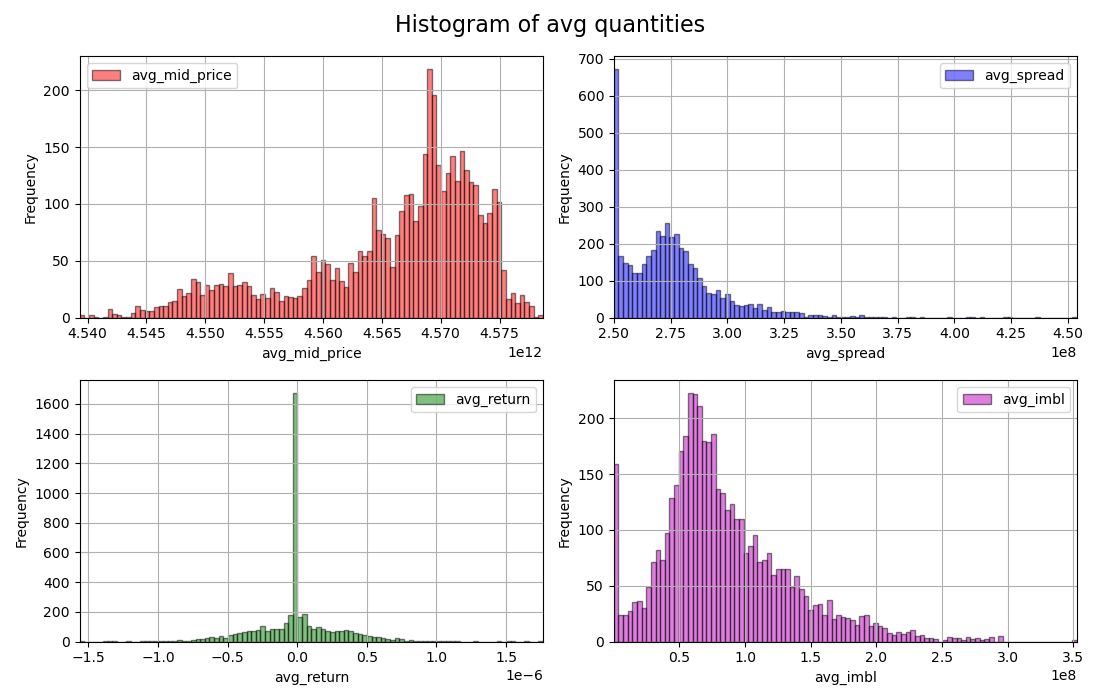

In [23]:
plot_histogram(df5s_ESH2,bins=100)

/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


Text(0.5, 0, 'OB imbalance')

Text(0, 0.5, 'Fwd price change')

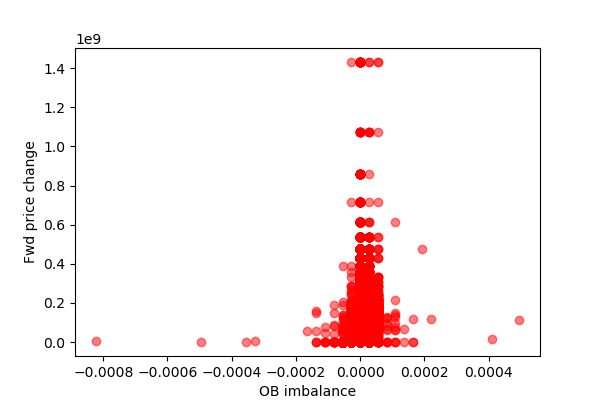

In [24]:
fig=plt.figure(figsize=(6,4))
plt.scatter(df_combined['log_return_00'][::10],df_combined['ob_imbl_00'][::10],color=bclr[0],alpha=0.5)
plt.xlabel('OB imbalance')
plt.ylabel('Fwd price change')
plt.show()

In [25]:
df_combined['ob_imbl_00'].corr(df_combined['log_return_00'])

0.13390274905886357

/home/rupam/anaconda3/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


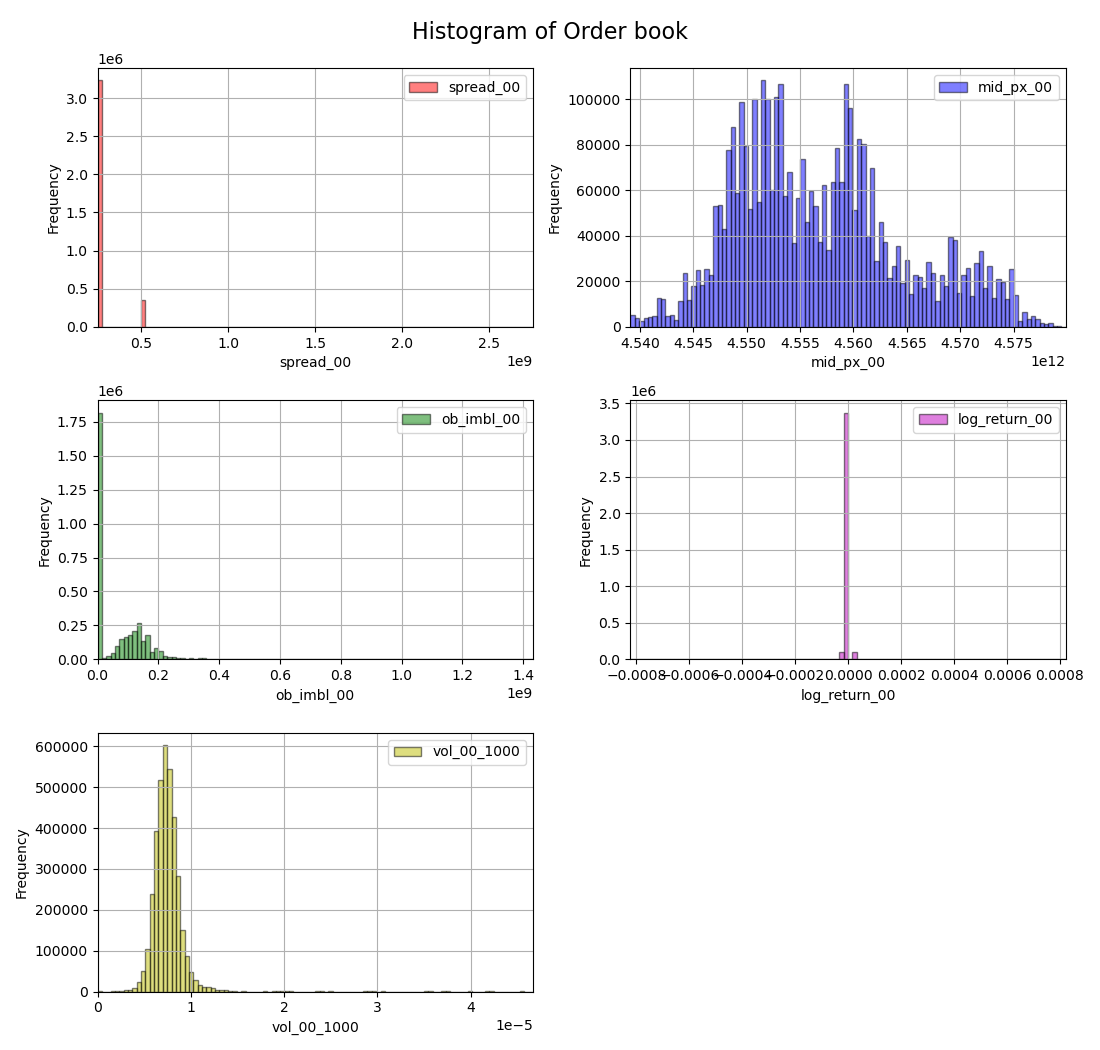

In [26]:
plot_histogram(df_combined,'Histogram of Order book',bins=100)